# Proyecto 3 - G3 - ML

Introducción.....

## 0. Libraries

In [98]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn import preprocessing

#temp
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap

from agglo_test import AgglomerativeHierarchicalClustering
from kmeans_own import MyKMeans

np.random.seed(2024)

## 1. Video Features Extracion

Para la extracción de features se usó la librería **Video Features**. No se escogió **Gluon** porque no ha tenido mantenimiento desde hace más de 1 año. 

Modelos disponibles: 

- S3D (Kinetics 400) (Paola)
- R(2+1)d RGB (IG-65M, Kinetics 400):
    - r2plus1d_18_16_kinetics
    - r2plus1d_34_32_ig65m_ft_kinetics *
    - r2plus1d_34_8_ig65m_ft_kinetics
- I3D-Net RGB + Flow (Kinetics 400)

Al final obtuvimos un conjunto de .npy, los cuales leeremos y 

El comando usado fue el siguiente:

```bash
# para usar con cpu agregar argumento
python .... device="cpu"

# i3d
python main.py feature_type=i3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# s3d
python main.py feature_type=s3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_18_16_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_18_16_kinetics" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_34_32_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_32_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_34_8_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_8_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"
```

#### Helper functions

In [ ]:
def create_video_paths(dir):
    video_paths = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.abspath(os.path.join(root, file))
                video_paths.append(video_path)

    output_file = 'video_paths.txt'
    with open(output_file, 'w') as f:
        for path in video_paths:
            f.write(path + '\n')

    print(f'Se han guardado los paths en el archivo: {output_file}')

# Ruta del directorio donde están los videos
directory = 'data/val_subset/'
create_video_paths(directory)

In [ ]:
def split_files_to_groups(directory, num_groups=5):
    
    # Lista de los .mp4
    mp4_files = [f for f in os.listdir(directory) if f.endswith('.mp4')]
    # Concatenar path
    mp4_paths = [os.path.join(directory, f) for f in mp4_files]
    # Shuffle
    np.random.shuffle(mp4_paths)

    # Dividir en grupos
    groups = [[] for _ in range(num_groups)]
    for i, path in enumerate(mp4_paths):
        groups[i % num_groups].append(path)

    # Escribir
    for i, group in enumerate(groups):
        with open(f'group_{i+1}.txt', 'w') as file:
            for path in group:
                file.write(f"{path}\n")
                
directory = 'C:\\Users\\Adrian Cespedes\\Desktop\\utec2024_1\\ml_temp\\Proy3-ML\\data\\temp'
split_files_to_groups(directory)

# 2. Load & Save Feature Vectors

In [21]:
def aggregate_features(feature_matrix):
    mean_features = np.mean(feature_matrix, axis=0)
    std_features = np.std(feature_matrix, axis=0)
    min_features = np.min(feature_matrix, axis=0)
    max_features = np.max(feature_matrix, axis=0)
    median_features = np.median(feature_matrix, axis=0)
    
    return np.concatenate([mean_features, std_features, min_features, max_features, median_features])

In [2]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    # Crear un diccionario de youtube_id a labels para acceso rápido
    labels_dict = labels_df.set_index('youtube_id')['label'].to_dict()
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue
        
        if youtube_id not in labels_dict:
            continue

        current_video_feature_avg = np.mean(current_video_feature, axis=0)
        video_features.append(current_video_feature_avg)
        
        current_video_label = labels_dict[youtube_id]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.array(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked, columns=['label'])

    return df_features, df_labels

In [43]:
def extract_test_videos(video_features_path, df_test_labels):
    video_features = []
    missing_videos_indices = []
    video_empty_frames = 0
    
    # Crear un diccionario de youtube_id a características para acceso rápido
    video_dict = {}
    
    # Asegurarse de que los archivos se procesen en orden alfabético
    for each_video in sorted(glob.glob(os.path.join(video_features_path, '*.npy'))):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue
        
        current_video_feature_avg = np.mean(current_video_feature, axis=0)
        video_dict[youtube_id] = current_video_feature_avg
    
    for index, row in df_test_labels.iterrows():
        youtube_id = row['youtube_id']
        if youtube_id in video_dict:
            video_features.append(video_dict[youtube_id])
        else:
            missing_videos_indices.append(index)
    
    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    if video_features:
        video_features_stacked = np.vstack(video_features)
        df_features = pd.DataFrame(video_features_stacked)
    else:
        df_features = pd.DataFrame()

    return df_features, missing_videos_indices

In [44]:
df_train_labels = pd.read_csv('./data/train_subset_10.csv')
df_val_labels = pd.read_csv('./data/val_subset_10.csv')
df_test_labels = pd.read_csv('./data/test_subset_10.csv')

X_train, Y_train = extract_video_data('./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}\n')

X_val, Y_val = extract_video_data('./data/val_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_val_labels)
X_val.dropna(inplace = True)
Y_val.dropna(inplace = True)

print(f'\nNúmero de videos cargados para validacion: {len(X_val)}')
print(f'Shape de nuestra matriz de videos para validacion: {X_val.shape}\n')

X_test, missing_indices = extract_test_videos('./data/test_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_test_labels)
X_test.dropna(inplace = True)

print(f'\nNúmero de videos cargados para test: {len(X_test)}')
print(f'Shape de nuestra matriz de videos para test: {X_test.shape}')
print("Índices de videos faltantes:", missing_indices)

Número de videos vacíos no agregados (./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 15

Número de videos cargados para entrenamiento: 5409
Shape de nuestra matriz de videos para entrenamiento: (5409, 512)

Número de videos vacíos no agregados (./data/val_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 0

Número de videos cargados para validacion: 426
Shape de nuestra matriz de videos para validacion: (426, 512)

Número de videos vacíos no agregados (./data/test_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 4

Número de videos cargados para test: 804
Shape de nuestra matriz de videos para test: (804, 512)
Índices de videos faltantes: [188]


# 3. Visualización de datos

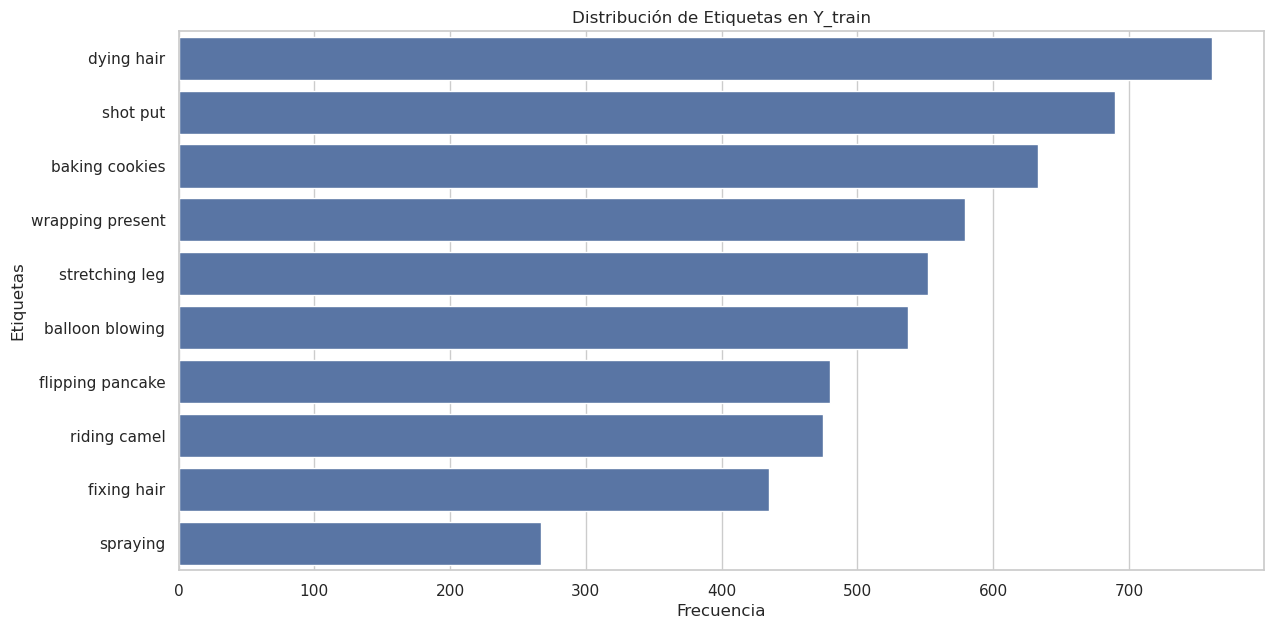

In [45]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(Y_train.iloc[:, 0], order=Y_train.iloc[:, 0].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Etiquetas en Y_train')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

# 4. Experimentación

In [46]:
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = PowerTransformer(method='yeo-johnson')
# scaler = QuantileTransformer()
normalized_data = scaler.fit_transform(X_train)
normalized_val = scaler.fit_transform(X_val)
normalized_test = scaler.fit_transform(X_test)

In [47]:
# Reducir la dimensionalidad usando PCA
pca = PCA(n_components=20)
pca_data = pca.fit_transform(normalized_data)
pca_val = pca.fit_transform(normalized_val)
pca_test = pca.fit_transform(normalized_test)

# Reducir la dimensionalidad usando t-SNE
tsne = TSNE()
tsne_data = tsne.fit_transform(normalized_data)
tsne_val = tsne.fit_transform(normalized_val)
tsne_test = tsne.fit_transform(normalized_test)

# Reducir la dimensionalidad usando UMAP
umap_reducer = umap.UMAP()
umap_data = umap_reducer.fit_transform(normalized_data)
umap_val = umap_reducer.fit_transform(normalized_val)
umap_test = umap_reducer.fit_transform(normalized_test)

In [48]:
# Reducir la dimensionalidad usando TriMap
trimap_data = trimap.TRIMAP().fit_transform(normalized_data)
trimap_val = trimap.TRIMAP().fit_transform(normalized_val)
trimap_test = trimap.TRIMAP().fit_transform(normalized_test)

# Reducir la dimensionalidad usando PaCMAP
pacmap_data = pacmap.PaCMAP().fit_transform(normalized_data, init="pca")
pacmap_val = pacmap.PaCMAP().fit_transform(normalized_val, init="pca")
pacmap_test = pacmap.PaCMAP().fit_transform(normalized_test, init="pca")

In [49]:
le = preprocessing.LabelEncoder()
# le.fit(Y_train.to_numpy().ravel())
Y_train_encoded = le.fit_transform(Y_train.to_numpy().ravel())
Y_val_encoded = le.fit_transform(Y_val.to_numpy().ravel())

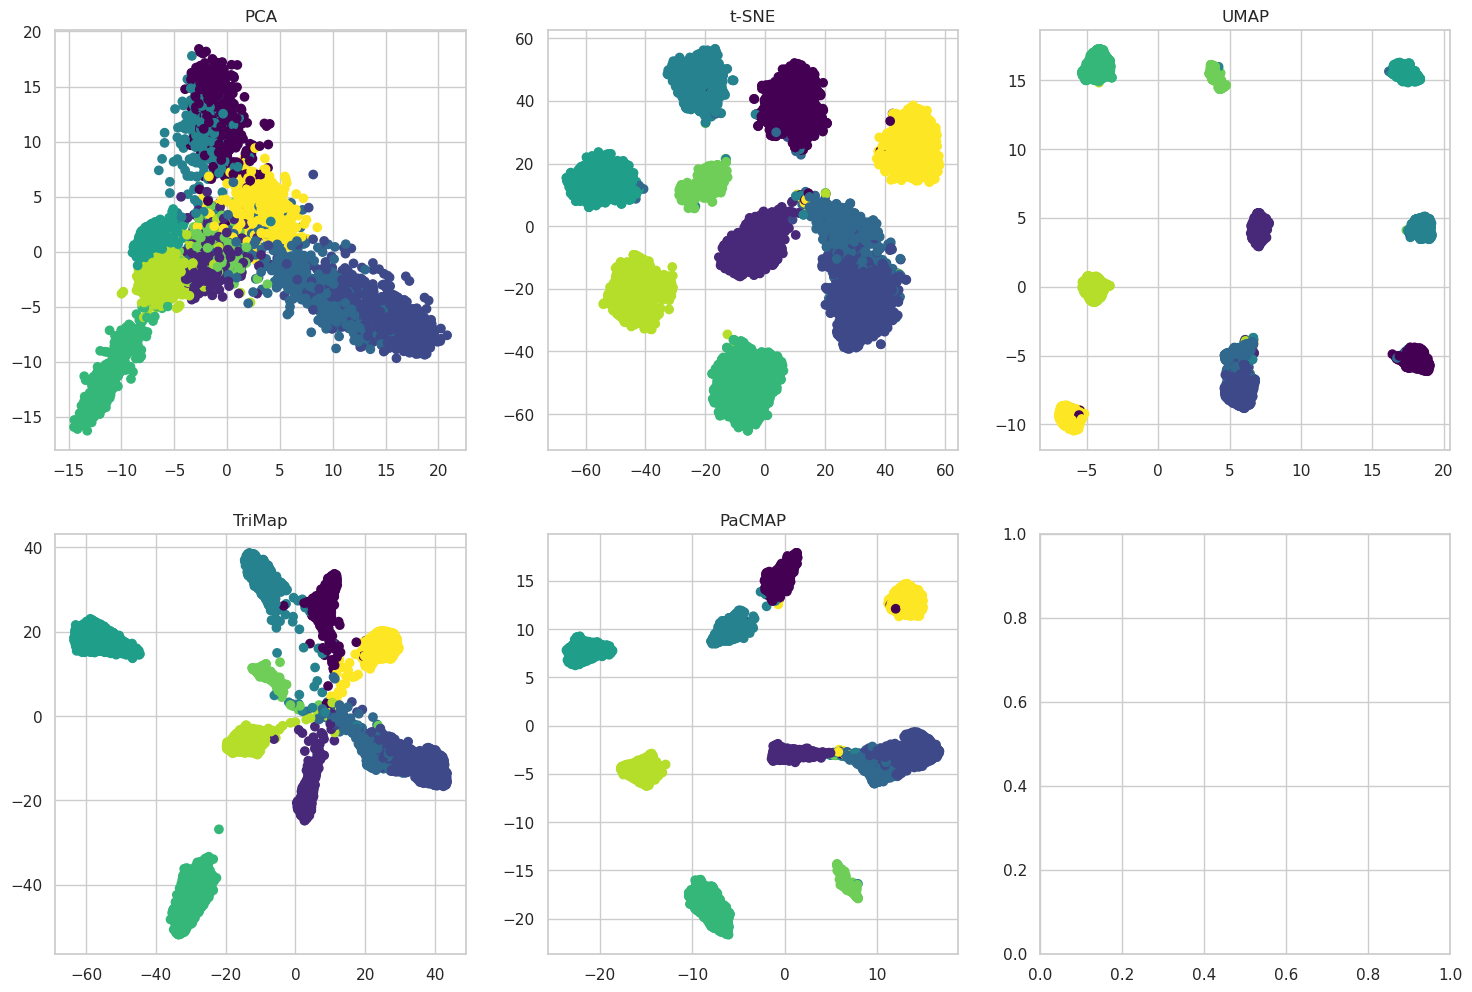

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0][0].scatter(pca_data[:, 0], pca_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[0][0].set_title('PCA')
axs[0][1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[0][1].set_title('t-SNE')
axs[0][2].scatter(umap_data[:, 0], umap_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[0][2].set_title('UMAP')
axs[1][0].scatter(trimap_data[:, 0], trimap_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[1][0].set_title('TriMap')
axs[1][1].scatter(pacmap_data[:, 0], pacmap_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[1][1].set_title('PaCMAP')
plt.show()

In [51]:
def evaluate_clustering(reduced_data, true_labels, method_name, clustering_algorithm='kmeans'):
    if clustering_algorithm == 'kmeans':
        # Aplicar K-means para clustering en los datos reducidos
        clusterer = KMeans(n_clusters=10, random_state=2024, algorithm='lloyd')
    elif clustering_algorithm == 'meanshift':
        # Aplicar Mean Shift para clustering en los datos reducidos
        clusterer = MeanShift()
    elif clustering_algorithm == 'dbscan':
        # Aplicar DBSCAN para clustering en los datos reducidos
        clusterer = DBSCAN(eps=0.5, min_samples=4)
    elif clustering_algorithm == 'agglomerative':
        # Aplicar Agglomerative Clustering para clustering en los datos reducidos
        clusterer = AgglomerativeClustering(n_clusters=10)

    predicted_labels = clusterer.fit_predict(reduced_data)
    
    # Calcular Silhouette Score
    silhouette_avg = silhouette_score(reduced_data, predicted_labels)
    
    # Calcular Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, predicted_labels)
    
    # Calcular Adjusted Mutual Information
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)

    print(f"{method_name} ({clustering_algorithm}) - Silhouette Score: {silhouette_avg:.4f}, Adjusted Rand Index: {ari:.4f}, Adjusted Mutual Information: {ami:.4f}")

In [ ]:
# Evaluar clustering con PCA
evaluate_clustering(pca_data, Y_train_encoded, "PCA", clustering_algorithm='kmeans')
evaluate_clustering(pca_data, Y_train_encoded, "PCA", clustering_algorithm='dbscan')

In [69]:
# Evaluar clustering con t-SNE
evaluate_clustering(tsne_data, Y_train_encoded, "t-SNE", clustering_algorithm='kmeans')
evaluate_clustering(tsne_data, Y_train_encoded, "t-SNE", clustering_algorithm='dbscan')

t-SNE (kmeans) - Silhouette Score: 0.6496, Adjusted Rand Index: 0.9412, Adjusted Mutual Information: 0.9478
t-SNE (dbscan) - Silhouette Score: -0.4721, Adjusted Rand Index: 0.0069, Adjusted Mutual Information: 0.2100


In [52]:
# Evaluar clustering con UMAP
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='kmeans')
# evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='meanshift')
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='dbscan')
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='agglomerative')

UMAP (kmeans) - Silhouette Score: 0.8344, Adjusted Rand Index: 0.9478, Adjusted Mutual Information: 0.9508
UMAP (dbscan) - Silhouette Score: 0.8909, Adjusted Rand Index: 0.8694, Adjusted Mutual Information: 0.9408
UMAP (agglomerative) - Silhouette Score: 0.8327, Adjusted Rand Index: 0.9465, Adjusted Mutual Information: 0.9503


In [53]:
# Evaluar clustering con TriMap
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='kmeans')
# evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='meanshift')
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='dbscan')
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='agglomerative')

TriMap (kmeans) - Silhouette Score: 0.6796, Adjusted Rand Index: 0.8462, Adjusted Mutual Information: 0.9117
TriMap (dbscan) - Silhouette Score: 0.0173, Adjusted Rand Index: 0.5321, Adjusted Mutual Information: 0.6892
TriMap (agglomerative) - Silhouette Score: 0.7101, Adjusted Rand Index: 0.9211, Adjusted Mutual Information: 0.9327


In [54]:
# Evaluar clustering con PaCMAP
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='kmeans')
# evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='meanshift')
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='dbscan')
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='agglomerative')

PaCMAP (kmeans) - Silhouette Score: 0.7621, Adjusted Rand Index: 0.9208, Adjusted Mutual Information: 0.9390
PaCMAP (dbscan) - Silhouette Score: 0.7323, Adjusted Rand Index: 0.6949, Adjusted Mutual Information: 0.8859
PaCMAP (agglomerative) - Silhouette Score: 0.7593, Adjusted Rand Index: 0.9257, Adjusted Mutual Information: 0.9375


In [95]:
# data = np.array([[1, 2], [2, 3], [3, 4], [5, 6], [7, 8]])
print(umap_data.shape)
k = 10
umbral = 0.1
mykm = MyKMeans(umap_data, k, umbral)
centroides, clusters = mykm.kmeans()
print(np.unique(clusters))
ari = adjusted_rand_score(Y_train_encoded, clusters)
print(ari)
print(silhouette_score(umap_data, clusters))

(5409, 2)
[0 1 2 3 4 5 6 7 8 9]
0.7200847402375333
0.65989494


In [96]:
k = 10
umbral = 0.1
mykm = MyKMeans(umap_val, k, umbral)
centroides, clusters = mykm.kmeans()
print(np.unique(clusters))
ari = adjusted_rand_score(Y_val_encoded, clusters)
print(ari)
print(silhouette_score(umap_val, clusters))

[0 1 2 3 4 5 6 7 8 9]
0.6167884459132839
0.68893117


In [97]:
k = 10
umbral = 0.1
mykm = MyKMeans(umap_test, k, umbral)
centroides, clusters = mykm.kmeans()
print(np.unique(clusters))
print(silhouette_score(umap_test, clusters))

[0 1 2 3 4 5 6 7 8 9]
0.6230309


In [92]:
def create_clustered_dataframe(df_test_labels, clusters, missing_indices, output_csv_path):
    # Verificar que la longitud de clusters sea la adecuada
    expected_length = len(df_test_labels)
    if len(clusters) != expected_length - len(missing_indices):
        raise ValueError(f"La longitud de 'clusters' ({len(clusters)}) no coincide con la longitud esperada ({expected_length - len(missing_indices)})")
    
    # Crear un DataFrame con youtube_id y sus clusters correspondientes
    clustered_data = []
    missing_index_set = set(missing_indices)
    cluster_index = 0
    
    for i, (index, row) in enumerate(df_test_labels.iterrows()):
        if i in missing_index_set:
            clustered_data.append({'youtube_id': row['youtube_id'], 'label': 0})
        else:
            clustered_data.append({'youtube_id': row['youtube_id'], 'label': clusters[cluster_index]})
            cluster_index += 1
    
    # Convertir a DataFrame
    df_clustered = pd.DataFrame(clustered_data)
    
    # Guardar el DataFrame resultante en un archivo CSV
    df_clustered.to_csv(output_csv_path, index=False)

create_clustered_dataframe(df_test_labels, clusters, missing_indices, './clustered_test_labels.csv')